This notebook generates a toy dataset of spectra using a Planck distribution and single gaussian feature.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [2]:
def planck(wavelength, T):
    '''Return an output intensity for a star with temperature T at some wavelength in nm.'''
    h = 6.626e-34
    c = 3e8
    k = 1.38e-23
    return 2 * h * c**2 / wavelength**5 * 1 / (np.exp(h * c / (wavelength * k * T)) - 1)

In [3]:
def generate_spectrum(bins, T, A, mu, sigma):
    '''Generate a normalized spectrum for star with temperature T and gaussian feature A*N(mu, sigma).'''
    wavelengths = np.linspace(0, 3e-6, num=bins+1)[1:] # don't use 0 wavelength
    spectrum = planck(wavelengths, T)
    norm_spectrum = spectrum / np.max(spectrum)
    
    noise = np.random.normal(0, .01, bins) 
    feature = 1 - A * np.exp(-(wavelengths - mu)**2 / 2 / sigma**2)
    return feature * norm_spectrum + noise

In [4]:
def sample_prior():
    '''Sample a point from test prior.'''
    T = np.random.uniform(2000, 7000)
    A = np.random.normal(.8, .1) # size of the dip should be fairly large
    mu = np.random.normal(1.5e-6, .01e-6) # dip should vaguely appear in the same place
    sigma = np.random.normal(.01e-6, .01e-6) # dip width should be narrow
    return T, A, mu, sigma

/home/tey/env/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


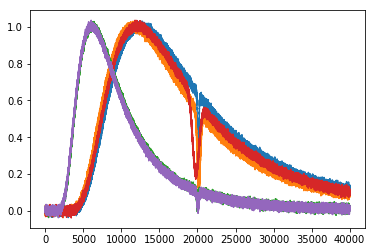

In [5]:
# Plot some random example spectra
bins = 40000
for _ in range(5):
    plt.plot(generate_spectrum(bins, *sample_prior()))

Create an iterator to mimic tftables data loader

In [5]:
sess = tf.InteractiveSession()

In [6]:
batch_size = 50
n_data = 24000 # total number of data samples
bins = 2**15

In [7]:
data = np.array([generate_spectrum(bins, *sample_prior()) for _ in range(n_data)])[:, :, np.newaxis]
placeholder_data = tf.placeholder(tf.float32, [n_data, bins, 1])
dataset = tf.data.Dataset.from_tensor_slices(placeholder_data)
dataset = dataset.batch(batch_size)
iterator = dataset.make_initializable_iterator()
d = iterator.get_next()
sess.run(iterator.initializer, feed_dict={placeholder_data: data})

/home/tey/env/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
W0205 15:19:42.600582 139678979589888 deprecation.py:323] From <ipython-input-7-7539ebc33d3a>:5: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


(50, 32768, 1)


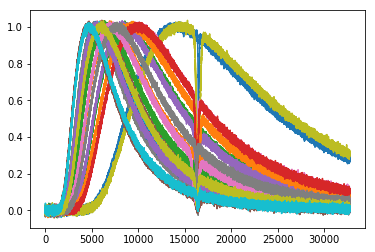

In [11]:
data_init = sess.run(d)
print(data_init.shape)
for spectrum in data_init[:20]:
    plt.plot(spectrum)